# Generate 9 Small Luminosity Datasets

In [170]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import norm, lognorm
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

rc('text', usetex=True)
sns.set_style("whitegrid")

# we will work with datasets of 2000 samples
n = 2000
tmp = pd.read_csv('mock_data.csv')
mass = tmp.mass_h[0 : n].as_matrix()
z = tmp.z[0 : n].as_matrix()

datasets = []
for seed in xrange(9):
    alpha1 = norm(10.709, 0.022).rvs()
    alpha2 = norm(0.359, 0.009).rvs()
    alpha3 = 2.35e14
    alpha4 = norm(1.10, 0.06).rvs()
    S = norm(0.155, 0.0009).rvs()
    sigma_L = 0.05
    mu_li = np.exp(alpha1) * ((mass / alpha3) ** (alpha2))* ((1+z) ** (alpha4))
    li = lognorm(S, scale=mu_li).rvs()
    observed = lognorm(sigma_L, scale=li).rvs()
    d = {
        'seed': seed,
        'alpha1': alpha1,
        'alpha2': alpha2,
        'alpha3': alpha3,
        'alpha4': alpha4,
        'S': S,
        'sigma_L': sigma_L,
        'lum_mu': mu_li,
        'lum': li,
        'lum_obs': observed,
        'mass': mass,
        'z': z,
    }
    datasets.append(d)


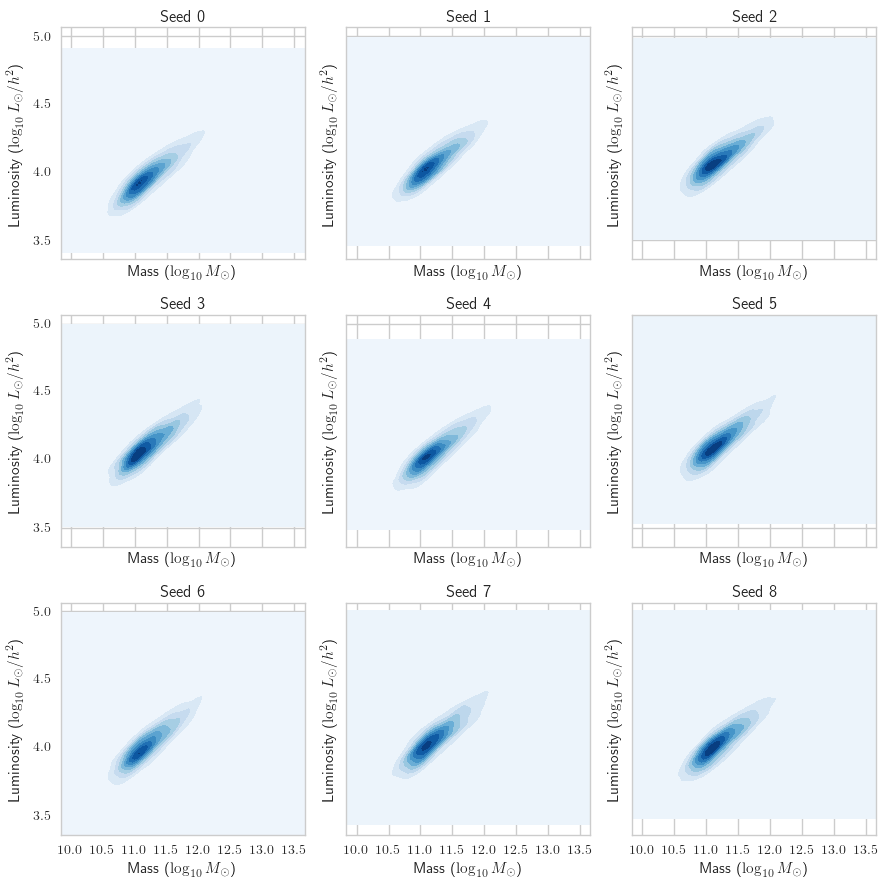

In [171]:
def log10(arr):
    return np.log(arr) / np.log(10)

f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    sns.kdeplot(log10(d['mass']), log10(d['lum']), shade=True, cmap='Blues', ax=ax)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

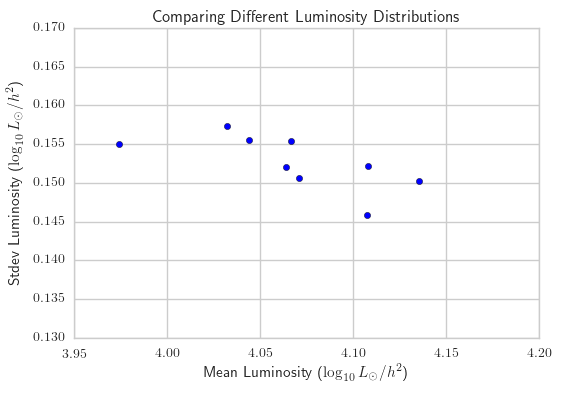

In [198]:
mus = []
stds = []
for i in xrange(9):
    d = datasets[i]
    mus.append(np.mean(log10(d['lum'])))
    stds.append(np.std(log10(d['lum'])))
plt.scatter(mus, stds)
plt.xlabel('Mean Luminosity ($\log_{10} L_{\odot} / h^2$)')
plt.ylabel('Stdev Luminosity ($\log_{10} L_{\odot} / h^2$)')
plt.title('Comparing Different Luminosity Distributions');

# Invert Observed Luminosities

In [173]:
for dataset in datasets:
    dataset['inv_lum'] = lognorm(dataset['sigma_L'], scale=dataset['lum_obs']).rvs()

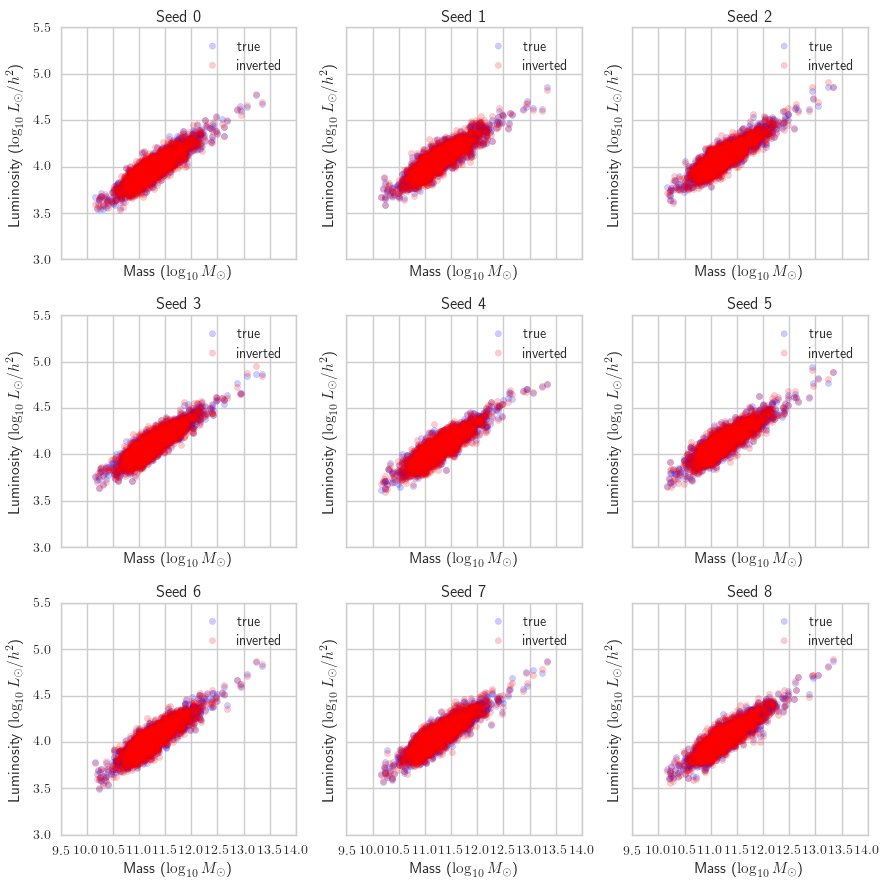

In [267]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.2, label='true')
    ax.scatter(log10(d['mass']), log10(d['inv_lum']), color='red', alpha=0.2, label='inverted')
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)
    ax.legend()

f.tight_layout()

# Invert Mass

In [175]:
for d in datasets:
    d['inv_mass_mu'] = d['alpha3'] * (d['inv_lum'] / (np.exp(d['alpha1']) * (1 + d['z']) ** d['alpha4'])) ** (1 / d['alpha2'])
    d['inv_mass'] = lognorm(d['S'], scale=d['inv_mass_mu']).rvs()

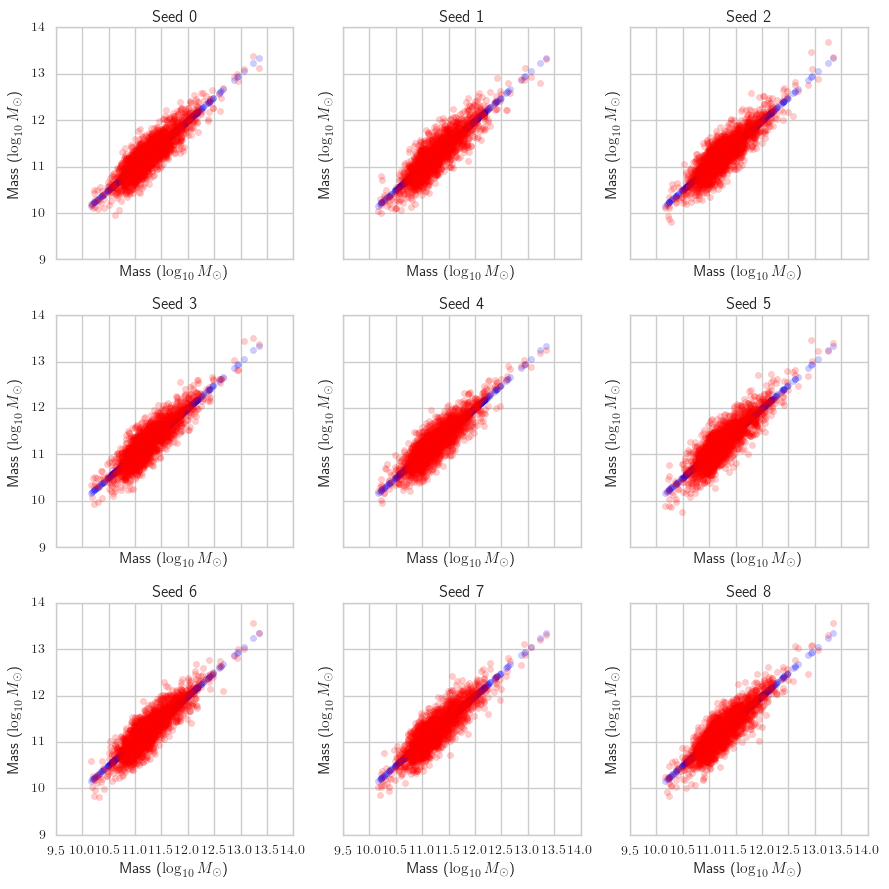

In [268]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    ax.scatter(log10(d['mass']), log10(d['mass']), color='blue', alpha=0.2)
    ax.scatter(log10(d['mass']), log10(d['inv_mass']), color='red', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

Now we fix seed0 and compare against to see how sensitive our inversions are to the drawn hyperparameters.

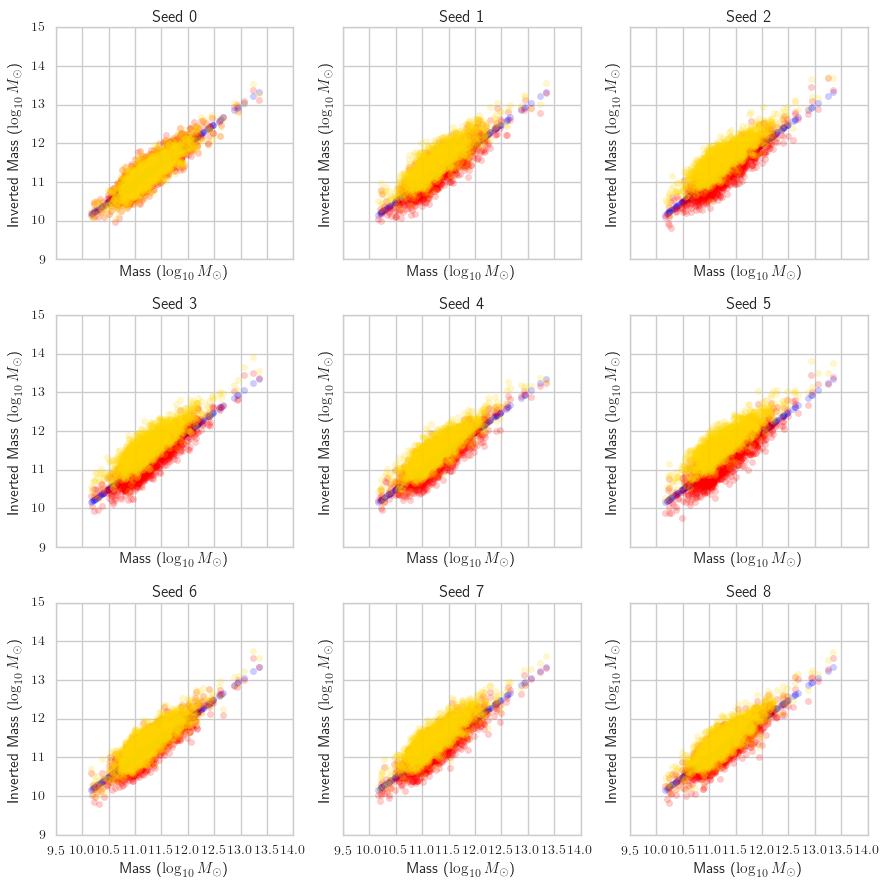

In [197]:
for d in datasets:
    fixed_seed = 0
    alpha1 = datasets[fixed_seed]['alpha1']
    alpha2 = datasets[fixed_seed]['alpha2']
    alpha3 = datasets[fixed_seed]['alpha3']
    alpha4 = datasets[fixed_seed]['alpha4']
    S = datasets[fixed_seed]['S']
    d['seed_inv_mass_mu'] = alpha3 * (d['inv_lum'] / (np.exp(alpha1) * (1 + d['z']) ** alpha4)) ** (1 / alpha2)
    d['seed_inv_mass'] = lognorm(S, scale=d['seed_inv_mass_mu']).rvs()

f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    ax.scatter(log10(d['mass']), log10(d['mass']), color='blue', alpha=0.2)
    ax.scatter(log10(d['mass']), log10(d['inv_mass']), color='red', alpha=0.2)
    ax.scatter(log10(d['mass']), log10(d['seed_inv_mass']), color='gold', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Inverted Mass ($\log_{10} M_{\odot}$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

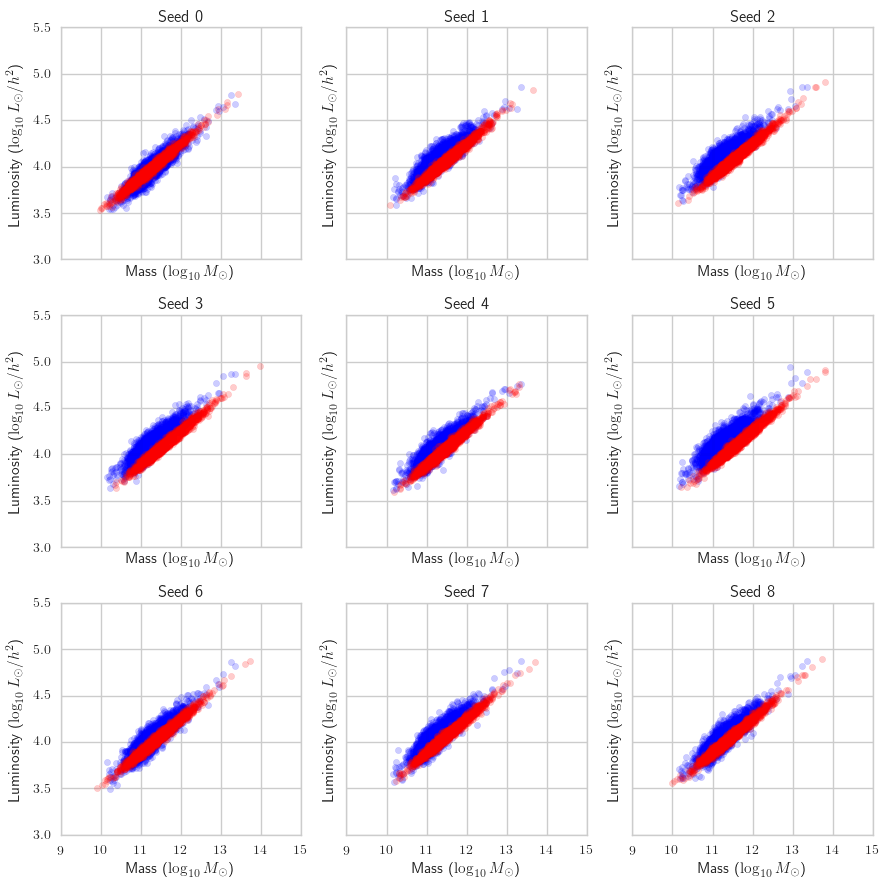

In [178]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.2)
    ax.scatter(log10(d['seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

In [194]:
import hmf
import scipy.interpolate as interpolate

class MassPrior():
    """
    Class to represent mass prior distribution.
    Initialize with mass and probability arrays.
    Can both evaluate and sample from distribution.
    """
    def __init__(self, mass, prob):
        self.mass = mass
        self.prob = prob
        self.min = mass.min()
        self.max = mass.max()
        # have to add 0,1 samples for interpolation bounds
        cumsum = np.append(np.append(np.array([0]), np.cumsum(prob)), np.array([1]))
        masses = np.append(np.append(np.array([self.min-1]), self.mass), np.array([self.max+1]))
        self.inv_cdf = interpolate.interp1d(cumsum, masses)

    def pdf(self, mass):
        ret = self._pdf(mass)
        if (len(mass) > 1):
            ret = np.prod(ret)
        return ret
    
    def logpdf(self, mass):
        ret = np.log(self._pdf(mass))
        if (len(mass) > 1):
            ret = np.sum(ret)
        return ret
        
    def _pdf(self, mass):
        if np.any(mass < self.min) or np.any(mass > self.max):
            raise Exception('out of range')
        right_ind = np.searchsorted(self.mass, mass)
        left_ind = right_ind - 1
        # find where we fall in interval between masses
        f = (mass - self.mass[left_ind]) / (self.mass[right_ind] - self.mass[left_ind])
        return f * self.prob[right_ind] + (1-f) * self.prob[left_ind]
        
    def rvs(self, size=1):
        return self.inv_cdf(np.random.rand(size))
    
    @staticmethod
    def default():
        h = 0.73
        Mmin = 10.2358590918
        Mmax = 14.3277327776
        mf = hmf.MassFunction(Mmin=Mmin, Mmax=Mmax, cosmo_model=hmf.cosmo.WMAP5, hmf_model=hmf.fitting_functions.Tinker10)
        return MassPrior(mf.m*h, mf.dndm / sum(mf.dndm)) # the h normalization is important

mass_prior = MassPrior.default()
samplings = []
for i in xrange(9):
    np.random.seed(i)
    fixed_seed = 0
    alpha1 = datasets[fixed_seed]['alpha1']
    alpha2 = datasets[fixed_seed]['alpha2']
    alpha3 = datasets[fixed_seed]['alpha3']
    alpha4 = datasets[fixed_seed]['alpha4']
    S = datasets[fixed_seed]['S']
    s = dict()
    s['mass'] = mass_prior.rvs(size=n)
    s['lum_mu'] = np.exp(alpha1) * ((s['mass'] / alpha3) ** (alpha2))* ((1+z) ** (alpha4))
    s['lum'] = lognorm(S, scale=s['lum_mu']).rvs()
    s['seed'] = i
    samplings.append(s)

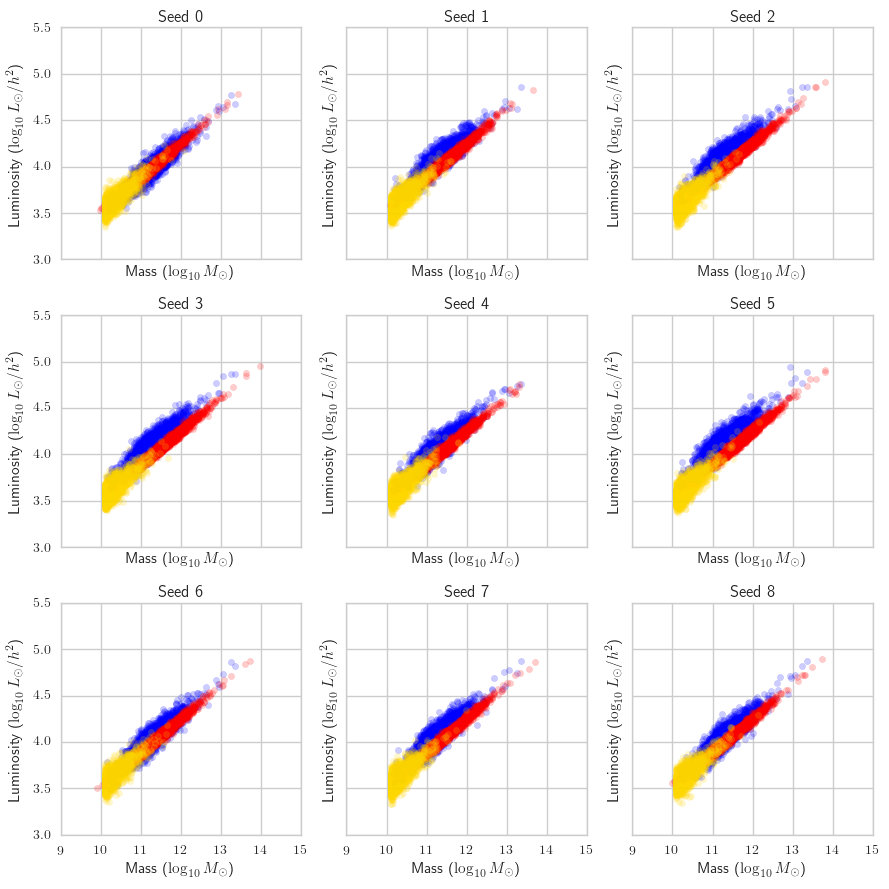

In [180]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    s = samplings[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.2)
    ax.scatter(log10(d['seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.2)
    ax.scatter(log10(s['mass']), log10(s['lum']), color='gold', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

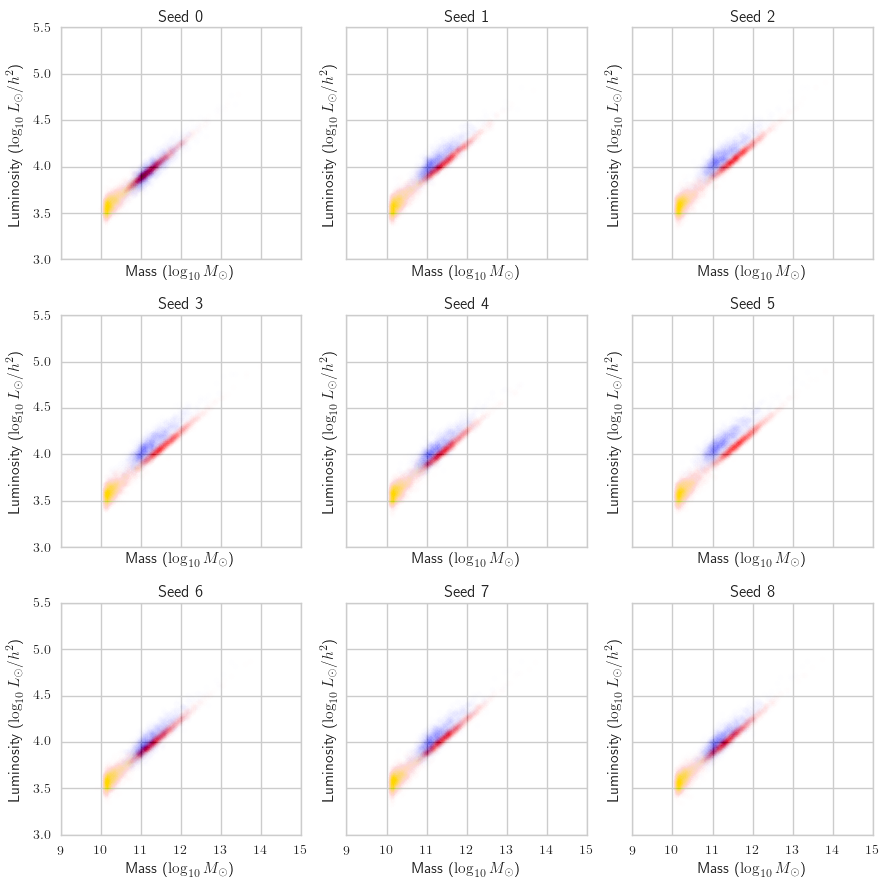

In [184]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    s = samplings[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.005)
    ax.scatter(log10(d['seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.005)
    ax.scatter(log10(s['mass']), log10(s['lum']), color='gold', alpha=0.005)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

# Mass-Luminosity Scatter

See in the data that should be 5 sigma. Going to fix from now on.

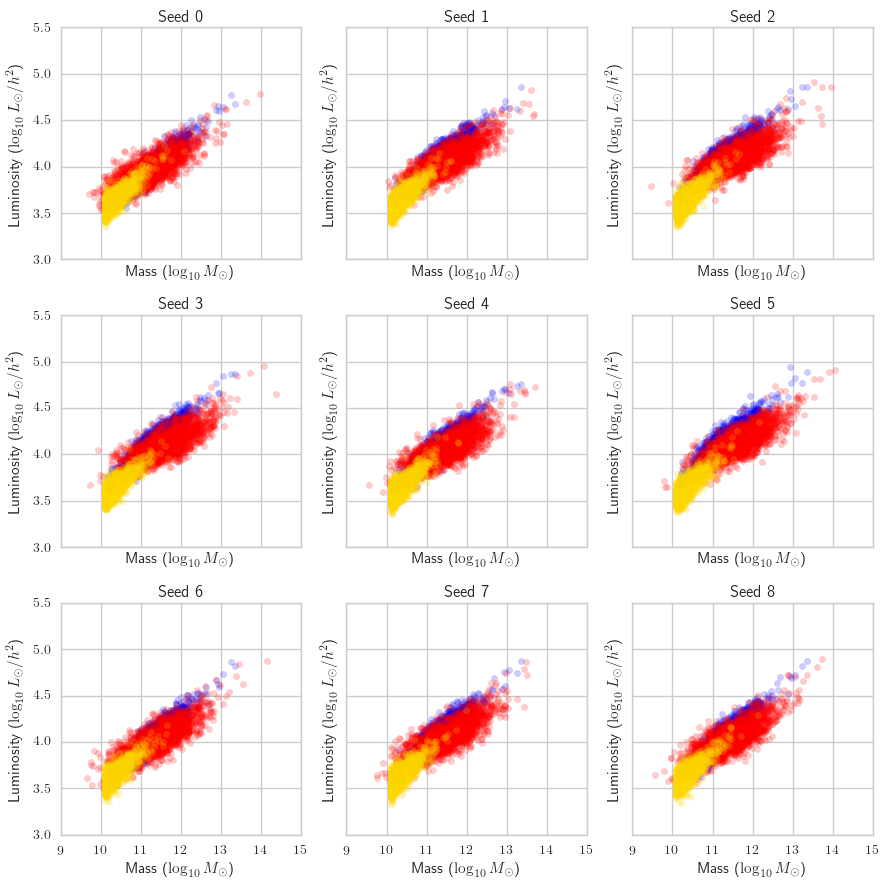

In [203]:
for d in datasets:
    fixed_seed = 0
    alpha1 = datasets[fixed_seed]['alpha1']
    alpha2 = datasets[fixed_seed]['alpha2']
    alpha3 = datasets[fixed_seed]['alpha3']
    alpha4 = datasets[fixed_seed]['alpha4']
    S = datasets[fixed_seed]['S'] * 5 # here is where we multiply by five now
    d['5S_seed_inv_mass_mu'] = alpha3 * (d['inv_lum'] / (np.exp(alpha1) * (1 + d['z']) ** alpha4)) ** (1 / alpha2)
    d['5S_seed_inv_mass'] = lognorm(S, scale=d['seed_inv_mass_mu']).rvs()

f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    s = samplings[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.2)
    ax.scatter(log10(d['5S_seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.2)
    ax.scatter(log10(s['mass']), log10(s['lum']), color='gold', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

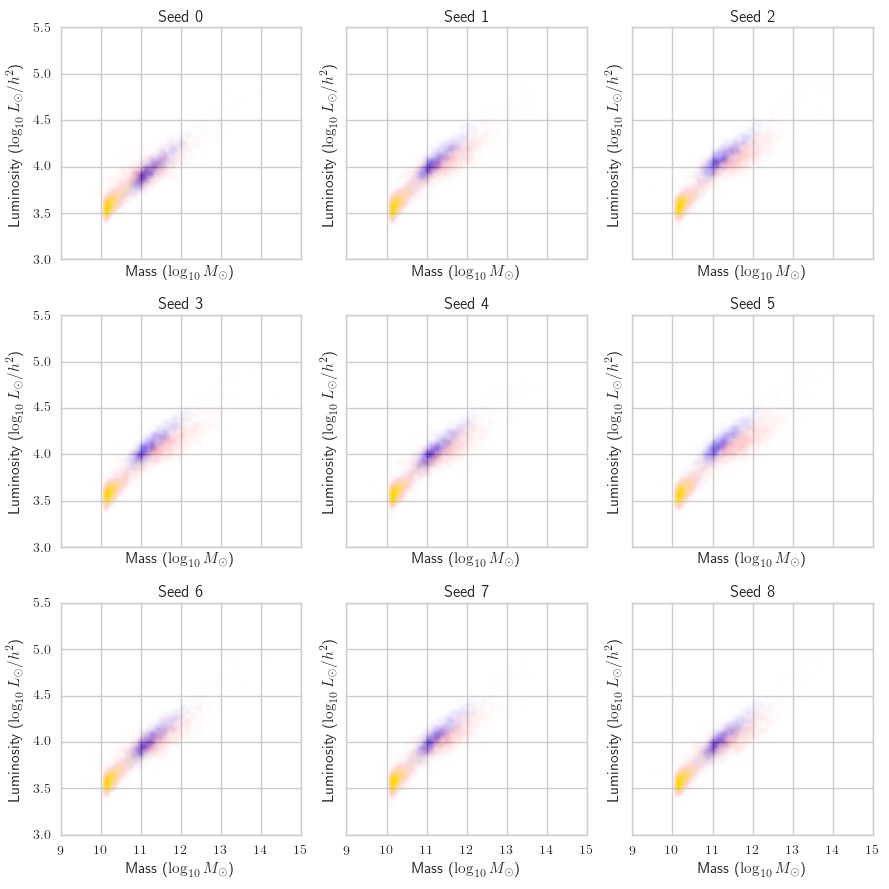

In [204]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    s = samplings[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.005)
    ax.scatter(log10(d['5S_seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.005)
    ax.scatter(log10(s['mass']), log10(s['lum']), color='gold', alpha=0.005)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

# Likelihood

In [196]:
datasets[0]

{'S': 0.15513828001473409,
 'alpha1': 10.706690446577582,
 'alpha2': 0.37130673484214138,
 'alpha3': 235000000000000.0,
 'alpha4': 1.0006793577014195,
 'inv_lum': array([  6040.2417993 ,   8674.31346097,   9703.04458999, ...,
         18563.90659549,  15558.01831009,   8623.242536  ]),
 'inv_mass': array([  4.89799022e+10,   1.43231705e+11,   1.69133612e+11, ...,
          1.02175470e+12,   5.32851456e+11,   1.54923088e+11]),
 'inv_mass_mu': array([  5.19600279e+10,   1.46866057e+11,   2.00744665e+11, ...,
          1.07029482e+12,   6.65438836e+11,   1.45525818e+11]),
 'lum': array([  6035.55215078,   8570.06582891,  10331.35292361, ...,
         17958.06022784,  14561.04397269,   9131.83645496]),
 'lum_mu': array([  7717.41794579,   7517.76002988,  12470.24581225, ...,
         12943.61833766,  11694.58696188,   7228.10195838]),
 'lum_obs': array([  6287.3343969 ,   8851.67046748,   9738.64196364, ...,
         17493.18965845,  15962.83222583,   8757.96212061]),
 'mass': array([  1.0

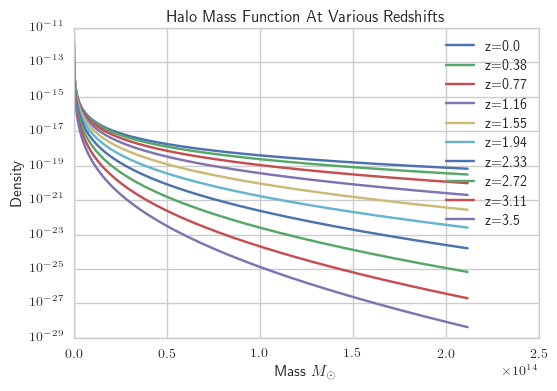

In [269]:
for z in np.linspace(0, 3.5, 10):
    h = 0.73
    Mmin = 10.2358590918
    Mmax = 14.3277327776
    mf = hmf.MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, cosmo_model=hmf.cosmo.WMAP5, hmf_model=hmf.fitting_functions.Tinker10)
    plt.plot(mf.m, mf.dndm, label='z={}'.format(str(z)[:4]))
    plt.ylabel('Density')
    plt.xlabel('Mass $M_{\odot}$')
    plt.gca().set_yscale('log')
    plt.legend()
plt.title('Halo Mass Function At Various Redshifts');

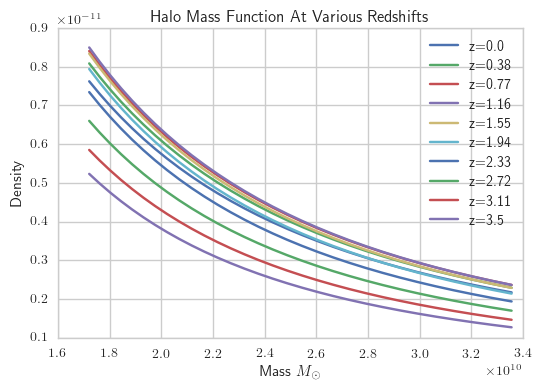

In [270]:
for z in np.linspace(0, 3.5, 10):
    h = 0.73
    Mmin = 10.2358590918
    Mmax = 14.3277327776
    mf = hmf.MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, cosmo_model=hmf.cosmo.WMAP5, hmf_model=hmf.fitting_functions.Tinker10)
    n = 30
    plt.plot(mf.m[:n], mf.dndm[:n], label='z={}'.format(str(z)[:4]))
    plt.ylabel('Density')
    plt.xlabel('Mass $M_{\odot}$')
    plt.legend()
plt.title('Halo Mass Function At Various Redshifts');

In [247]:
import hmf
import scipy.interpolate as interpolate
import pandas as pd
import numpy as np
from scipy.stats import lognorm, norm


class Grid():
    """
    Manages redshift bins.
    """

    def __init__(self, mmin=0, mmax=3.5, nbins=20):
        self.redshifts = np.linspace(mmin, mmax, nbins)
        self.nbins = nbins

    def snap(self, z):
        ind = np.minimum(self.nbins - 1, np.searchsorted(self.redshifts, z))
        return self.redshifts[ind]


class MassPrior():
    """
    Class to represent mass prior distribution.
    Initialize with mass and probability arrays.
    Can both evaluate and sample from distribution.
    """

    def __init__(self, mass, prob):
        self.mass = mass
        self.prob = prob
        self.min = mass.min()
        self.max = mass.max()
        # have to add 0,1 samples for interpolation bounds
        cumsum = np.append(np.append(np.array([0]), np.cumsum(prob)), np.array([1]))
        masses = np.append(np.append(np.array([self.min - 1]), self.mass), np.array([self.max + 1]))
        self.inv_cdf = interpolate.interp1d(cumsum, masses)

    def pdf(self, mass):
        ret = self._pdf(mass)
        if (len(mass) > 1):
            ret = np.prod(ret)
        return ret

    def logpdf(self, mass):
        ret = np.log(self._pdf(mass))
        if (len(mass) > 1):
            ret = np.sum(ret)
        return ret

    def _pdf(self, mass):
        if np.any(mass < self.min) or np.any(mass > self.max):
            raise Exception('out of range')
        right_ind = np.searchsorted(self.mass, mass)
        left_ind = right_ind - 1
        # find where we fall in interval between masses
        f = (mass - self.mass[left_ind]) / (self.mass[right_ind] - self.mass[left_ind])
        return f * self.prob[right_ind] + (1 - f) * self.prob[left_ind]

    def rvs(self, size=1):
        return self.inv_cdf(np.random.rand(size))


class TinkerPrior():
    def __init__(self, grid, h = 0.73, Mmin = 10.2358590918, Mmax = 14.3277327776):
        self.grid = grid
        self.grid_to_prior = dict()
        for z in grid.redshifts:
            mf = hmf.MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, \
                                  cosmo_model=hmf.cosmo.WMAP5, \
                                  hmf_model=hmf.fitting_functions.Tinker10)
            self.grid_to_prior[z] = MassPrior(mf.m * h, mf.dndm / sum(mf.dndm))

    def fetch(self, z):
        return self.grid_to_prior[self.grid.snap(z)]

    def pdf(self, mass, z):
        ret = self.fetch(z)._pdf(mass)
        if (len(mass) > 1):
            ret = np.prod(ret)
        return ret

    def logpdf(self, mass, z):
        ret = np.log(self.fetch(z)._pdf(mass))
        if (len(mass) > 1):
            ret = np.sum(ret)
        return ret

    def rvs(self, z, size=1):
        return self.fetch(z).inv_cdf(np.random.rand(size))


class DataSamples():
    def __init__(self, grid, mass, lum, z):
        self.grid = grid
        grid_to_masses = dict()
        grid_to_luminosities = dict()
        snapzs = grid.snap(z)
        for snapz in grid.redshifts:
            grid_to_masses[snapz] = []
            grid_to_luminosities[snapz] = []
        for i in xrange(len(mass)):
            grid_to_masses[snapzs[i]].append(mass[i])
            grid_to_luminosities[snapzs[i]].append(lum[i])
        self.grid_to_samples = dict()
        for snapz in grid.redshifts:
            self.grid_to_samples[snapz] = np.array([grid_to_masses[snapz], \
                                                    grid_to_luminosities[snapz]]) \
                                                    .transpose()

    def get_mass(self, z):
        snapz = self.grid.snap(z)
        return self.grid_to_samples[snapz][:, 0]

    def get_lum(self, z):
        snapz = self.grid.snap(z)
        return self.grid_to_samples[snapz][:, 1]


class LikelihoodTest():
    def __init__(self, grid, prior, samples, lum_obs, z):
        self.grid = grid
        self.prior = prior
        self.samples = samples
        self.lum_obs = lum_obs
        self.z = z
        self.snapz = grid.snap(z)
        self.sigma_L = 0.05

    def true_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
        ret = 0
        for i in xrange(len(self.lum_obs)):
            if i % 1000 == 0:
                print i
            # 2d integral (mass, lum)
            lum_obs = self.lum_obs[i]
            n = len(lum_obs)
            if n == 0:
                continue
            snapz = self.snapz[i]
            mass = self.samples.get_mass(snapz)
            lum_mu = np.exp(alpha1) * ((mass / alpha3) ** alpha2) * ((1 + snapz) ** alpha4)
            lum = lognorm(S, scale=lum_mu).rvs(n)
            val = np.sum(lognorm(self.sigma_L, scale=lum).pdf(lum_obs))
            ret += np.log(val) - np.log(n)
        return ret

    def naive_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
        raise NotImplemented()

    def importance_sampling_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
        raise NotImplemented()


# test
np.random.seed(0)
alpha1 = norm(10.709, 0.022).rvs()
alpha2 = norm(0.359, 0.009).rvs()
alpha3 = 2.35e14
alpha4 = norm(1.10, 0.06).rvs()
S = norm(0.155, 0.0009).rvs()
data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')
grid = Grid()
prior = TinkerPrior(grid)
samples = DataSamples(grid, data.mass.as_matrix(), data.lum.as_matrix(), data.z.as_matrix())
test = LikelihoodTest(grid, prior, samples, data.lum_obs.as_matrix(), data.z.as_matrix())
test.true_log_likelihood(alpha1, alpha2, alpha3, alpha4, S)

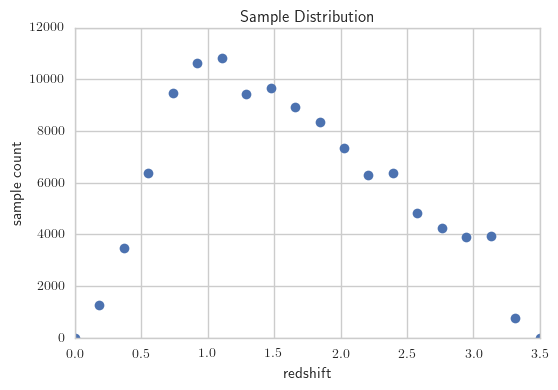

In [257]:
keys = np.sort(samples.grid_to_samples.keys())
counts = map(lambda k: samples.grid_to_samples[k].shape[0], keys)
plt.plot(keys, counts, 'o')
plt.xlabel('redshift')
plt.ylabel('sample count')
plt.title('Sample Distribution');

### True Likelihood Calculation

The likelihood under hyperparameters H for a single galaxy is 

$$\iint P(L_{obs}|L)P(L|M,z,H),P(M|z)dMdL$$ 

We can generate M-L samples from P(L|M,z,H),P(M|z). We use the true mass samples at fixed redshift and generate luminosities for each one. Lets call the set of these M-L samples $T(z,H)$, since the samples are a dependent on z and H. Then we use monte-carlo integration

$$\iint P(L_{obs}|L)dP(L,M|z,H) \sim \frac{1}{N_S} \sum_{M,L,L_{obs} \sim T(z,H)} P(L_{obs}|L)$$

Generalizing this for each galaxy in G we have

$$\mathcal{L} \sim \prod_{g \in G} \left[\frac{1}{N_{T(z^g,H)}} \sum_{M^g,L^g,L_{obs}^g \sim T(z^g,H)} P(L_{obs}^g|L^g) \right]$$

and taking the log

$$\mathcal{l} \sim \sum_{g \in G} -\log({N_{T(z^g,H)}}) + \log\left[ \sum_{M^g,L^g,L_{obs}^g \sim T(z^g,H)} P(L_{obs}^g|L^g) \right]$$

... but then we never use 'true' L samples - gues this is ok.


### Naive Likelihood Calculation

The only difference is the sampling distribution, specifically how we sample mass. Now we draw mass from the tinker prior. Let $N(z^g,H)$ denote this sampling. Then we have 

$$\mathcal{l} \sim \sum_{g \in G} -\log({N_{N(z^g,H)}}) + \log\left[ \sum_{M^g,L^g,L_{obs}^g \sim N(z^g,H)} P(L_{obs}^g|L^g) \right]$$

### Importance Sampling Likelihood Calculation

Now we draw M-L tuples from a biased distribution which we must be able to evaluate $Q(M^g,L^g,L_{obs}^g,z^g,H)$ and generate samples $B(z^g,H)$ from. Then we have

$$\mathcal{l} \sim \sum_{g \in G} -\log({N_{B(z^g,H)}}) + \log\left[ \sum_{M^g,L^g,z^g,L_{obs}^g \sim B(z^g,H)} \frac{P(L_{obs}^g|L^g)P(L^g|M^g,z^g,H)P(M^g|z^g)}{Q(M^g,L^g,L_{obs}^g,z^g,H)} \right]$$

### Performance Improvement

Compute samples and weights for each redshift bin, then only thing that changes between galaxies in a bin is $P(L^g_{obs}|L^g)$. Iterate through one redshift bin at a time. This will reduce computation by factor of 2 (see exp below).

$$\mathcal{l} \sim \sum_{g \in G} -\log({N_{T(z^g,H)}}) + \log\left[ \sum_{M^g,L^g,L_{obs}^g \sim T(z^g,H)} P(L_{obs}^g|L^g) \right]$$

In [264]:
mass = data.mass
snapz = 10
lum_obs = data.lum_obs
%time lum_mu = np.exp(alpha1) * ((mass / alpha3) ** alpha2) * ((1 + snapz) ** alpha4)
%time lum = lognorm(S, scale=lum_mu).rvs()
%time val = lognorm(0.05, scale=lum).pdf(lum_obs)

CPU times: user 6.27 ms, sys: 1.8 ms, total: 8.07 ms
Wall time: 6.95 ms
CPU times: user 8.81 ms, sys: 1.62 ms, total: 10.4 ms
Wall time: 10.8 ms
CPU times: user 14.9 ms, sys: 2.62 ms, total: 17.5 ms
Wall time: 18.9 ms
